In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from collections import deque
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
env = gym.make('MountainCarContinuous-v0')
print(env.action_space.sample())
print(env.observation_space.sample())

[-0.36645082]
[ 0.5545785  -0.06527635]


In [2]:
class Actor(nn.Module) :
    def __init__(self, input_size, hidden_size, n_actions, lr, device=torch.device('cpu')):
        super(Actor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output = n_actions
        self.lr = lr
        self.device = device

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.mean_fc3 = nn.Linear(self.hidden_size, self.n_output)
        self.log_std_fc3 = nn.Linear(self.hidden_size, self.n_output)

        self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        mean = self.mean_fc3(x)

        log_std = self.log_std_fc3(x)

        return mean, torch.clamp(log_std, -20, 2)
    
    def act(self, state, explore=False):
        mean, log_std = self.forward(state)

        gaussian = Normal(0, 1)
        z = gaussian.sample().to(self.device)
        std = log_std.exp()

        action = torch.tanh(mean + std*z)
        log_prob = Normal(mean, std).log_prob(mean + std*z)

        if explore and np.random.rand() < 7e-1:
            m = mean.detach().numpy()
            s = std.detach().numpy()
            self.noise = OrnsteinUhlenbeckActionNoise(mean=m, sigma=s)
            noise = torch.from_numpy(self.noise())
            action += noise
            log_prob += noise

        return action, log_prob
    
actor = Actor(2,64,1, 1e-2)
summary(actor,
        input_size=(1,2),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Actor (Actor)                            [1, 2]               [1, 1]               --                   True
├─Linear (fc1)                           [1, 2]               [1, 64]              192                  True
├─Linear (fc2)                           [1, 64]              [1, 64]              4,160                True
├─Linear (mean_fc3)                      [1, 64]              [1, 1]               65                   True
├─Linear (log_std_fc3)                   [1, 64]              [1, 1]               65                   True
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

### Critic

In [3]:
class Critic(nn.Module) :
    def __init__(self, input_size, hidden_size, lr, device=torch.device('cpu')):
        super(Critic, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.device = device

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, 1)

        self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        return self.fc3(x)
critic = Critic(2,48,1, 1e-2)
summary(critic,
        input_size=(1,2),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Critic (Critic)                          [1, 2]               [1, 1]               --                   True
├─Linear (fc1)                           [1, 2]               [1, 48]              144                  True
├─Linear (fc2)                           [1, 48]              [1, 48]              2,352                True
├─Linear (fc3)                           [1, 48]              [1, 1]               49                   True
Total params: 2,545
Trainable params: 2,545
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

### A2C

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic, device=torch.device('cpu')):
        super(ActorCritic, self).__init__()
        self.actor = actor.to(device)
        self.critic = critic.to(device)
        self.device = device

    def save(self, model_name):
        torch.save(self.state_dict(), model_name + '.pt')

    def load(self, model_name):
        self.load_state_dict(torch.load(model_name + '.pt', map_location=self.device))

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret
    
    def train(self, gamma=0.9, num_episodes=5000):

        E = gym.make('MountainCarContinuous-v0')
        MAX_PATIENCE = 130
        act_losses = deque()
        crt_losses = deque()
        scores = deque()

        for ep in range(num_episodes):

            R = []
            Prob = []
            Values = []
            Delta = []
            state = torch.from_numpy(E.reset()[0])
            done = False
            count = 0
            patience = MAX_PATIENCE

            while not done:
                
                action, prob = self.actor.act(state, explore=True)
                Prob.append(prob)

                next_state, reward, term, trunc, _ = E.step(action.detach().numpy())
                next_state = torch.from_numpy(next_state)

                value_state = self.critic.forward(state)
                Values.append(value_state)
                value_next_state = self.critic.forward(next_state)
                
                td_target = reward + gamma*value_next_state
                td_error = td_target - value_state
                #print(td_error)
                Delta.append(td_error)

                #   if reward >= 0:
                #       patience = MAX_PATIENCE
                #   else:
                #       patience -= 1
                #       if patience == 0:
                #           done = True
                #           reward -= 100
                #   if(reward and trunc):
                #       reward -= 10
                #   if term:
                #       reward += 100
                done = term or trunc
                count += 1
                R.append(reward)

            # print(R)

            Prob = torch.stack(Prob).squeeze()
            Values = torch.stack(Values).squeeze()
            Delta = torch.stack(Delta).squeeze()

            act_loss = (- Prob * Delta.detach()).mean()
            crt_loss = self.critic.criterion(Values, Delta)

            self.actor.optimizer.zero_grad()
            act_loss.backward()
            self.actor.optimizer.step()

            self.critic.optimizer.zero_grad()
            crt_loss.backward()
            self.critic.optimizer.step()

            if ep % 100 == 0:
                print(ep, act_loss, crt_loss, '\n')

            act_losses.append(act_loss.item())
            crt_losses.append(crt_loss.item())
            scores.append(np.mean(R))

        episodes = np.arange(1, num_episodes + 1)

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        fig.suptitle('Actor and Critic Losses')

        ax1.plot(episodes, act_losses, 'g', label='Actor Loss')

        ax2.plot(episodes, crt_losses, 'b', label='Critic Loss')

        ax3.plot(episodes, scores, 'y', label='Scores')

        fig.legend()
        fig.set_figwidth(48)
        fig.set_figheight(26)


0 tensor(-0.0863, grad_fn=<MeanBackward0>) tensor(0.0040, grad_fn=<MseLossBackward0>) 

100 tensor(-2.0700, grad_fn=<MeanBackward0>) tensor(0.3914, grad_fn=<MseLossBackward0>) 

200 tensor(-2.0921, grad_fn=<MeanBackward0>) tensor(0.3925, grad_fn=<MseLossBackward0>) 

300 tensor(-1.6568, grad_fn=<MeanBackward0>) tensor(11.8156, grad_fn=<MseLossBackward0>) 

400 tensor(-1.9755, grad_fn=<MeanBackward0>) tensor(0.3509, grad_fn=<MseLossBackward0>) 

500 tensor(-1.9443, grad_fn=<MeanBackward0>) tensor(0.3406, grad_fn=<MseLossBackward0>) 

600 tensor(-1.7702, grad_fn=<MeanBackward0>) tensor(0.2881, grad_fn=<MseLossBackward0>) 

700 tensor(-1.6242, grad_fn=<MeanBackward0>) tensor(0.2422, grad_fn=<MseLossBackward0>) 

800 tensor(-1.3310, grad_fn=<MeanBackward0>) tensor(0.1709, grad_fn=<MseLossBackward0>) 

900 tensor(-0.9891, grad_fn=<MeanBackward0>) tensor(0.1013, grad_fn=<MseLossBackward0>) 

1000 tensor(-0.6630, grad_fn=<MeanBackward0>) tensor(0.0578, grad_fn=<MseLossBackward0>) 

1100 tenso

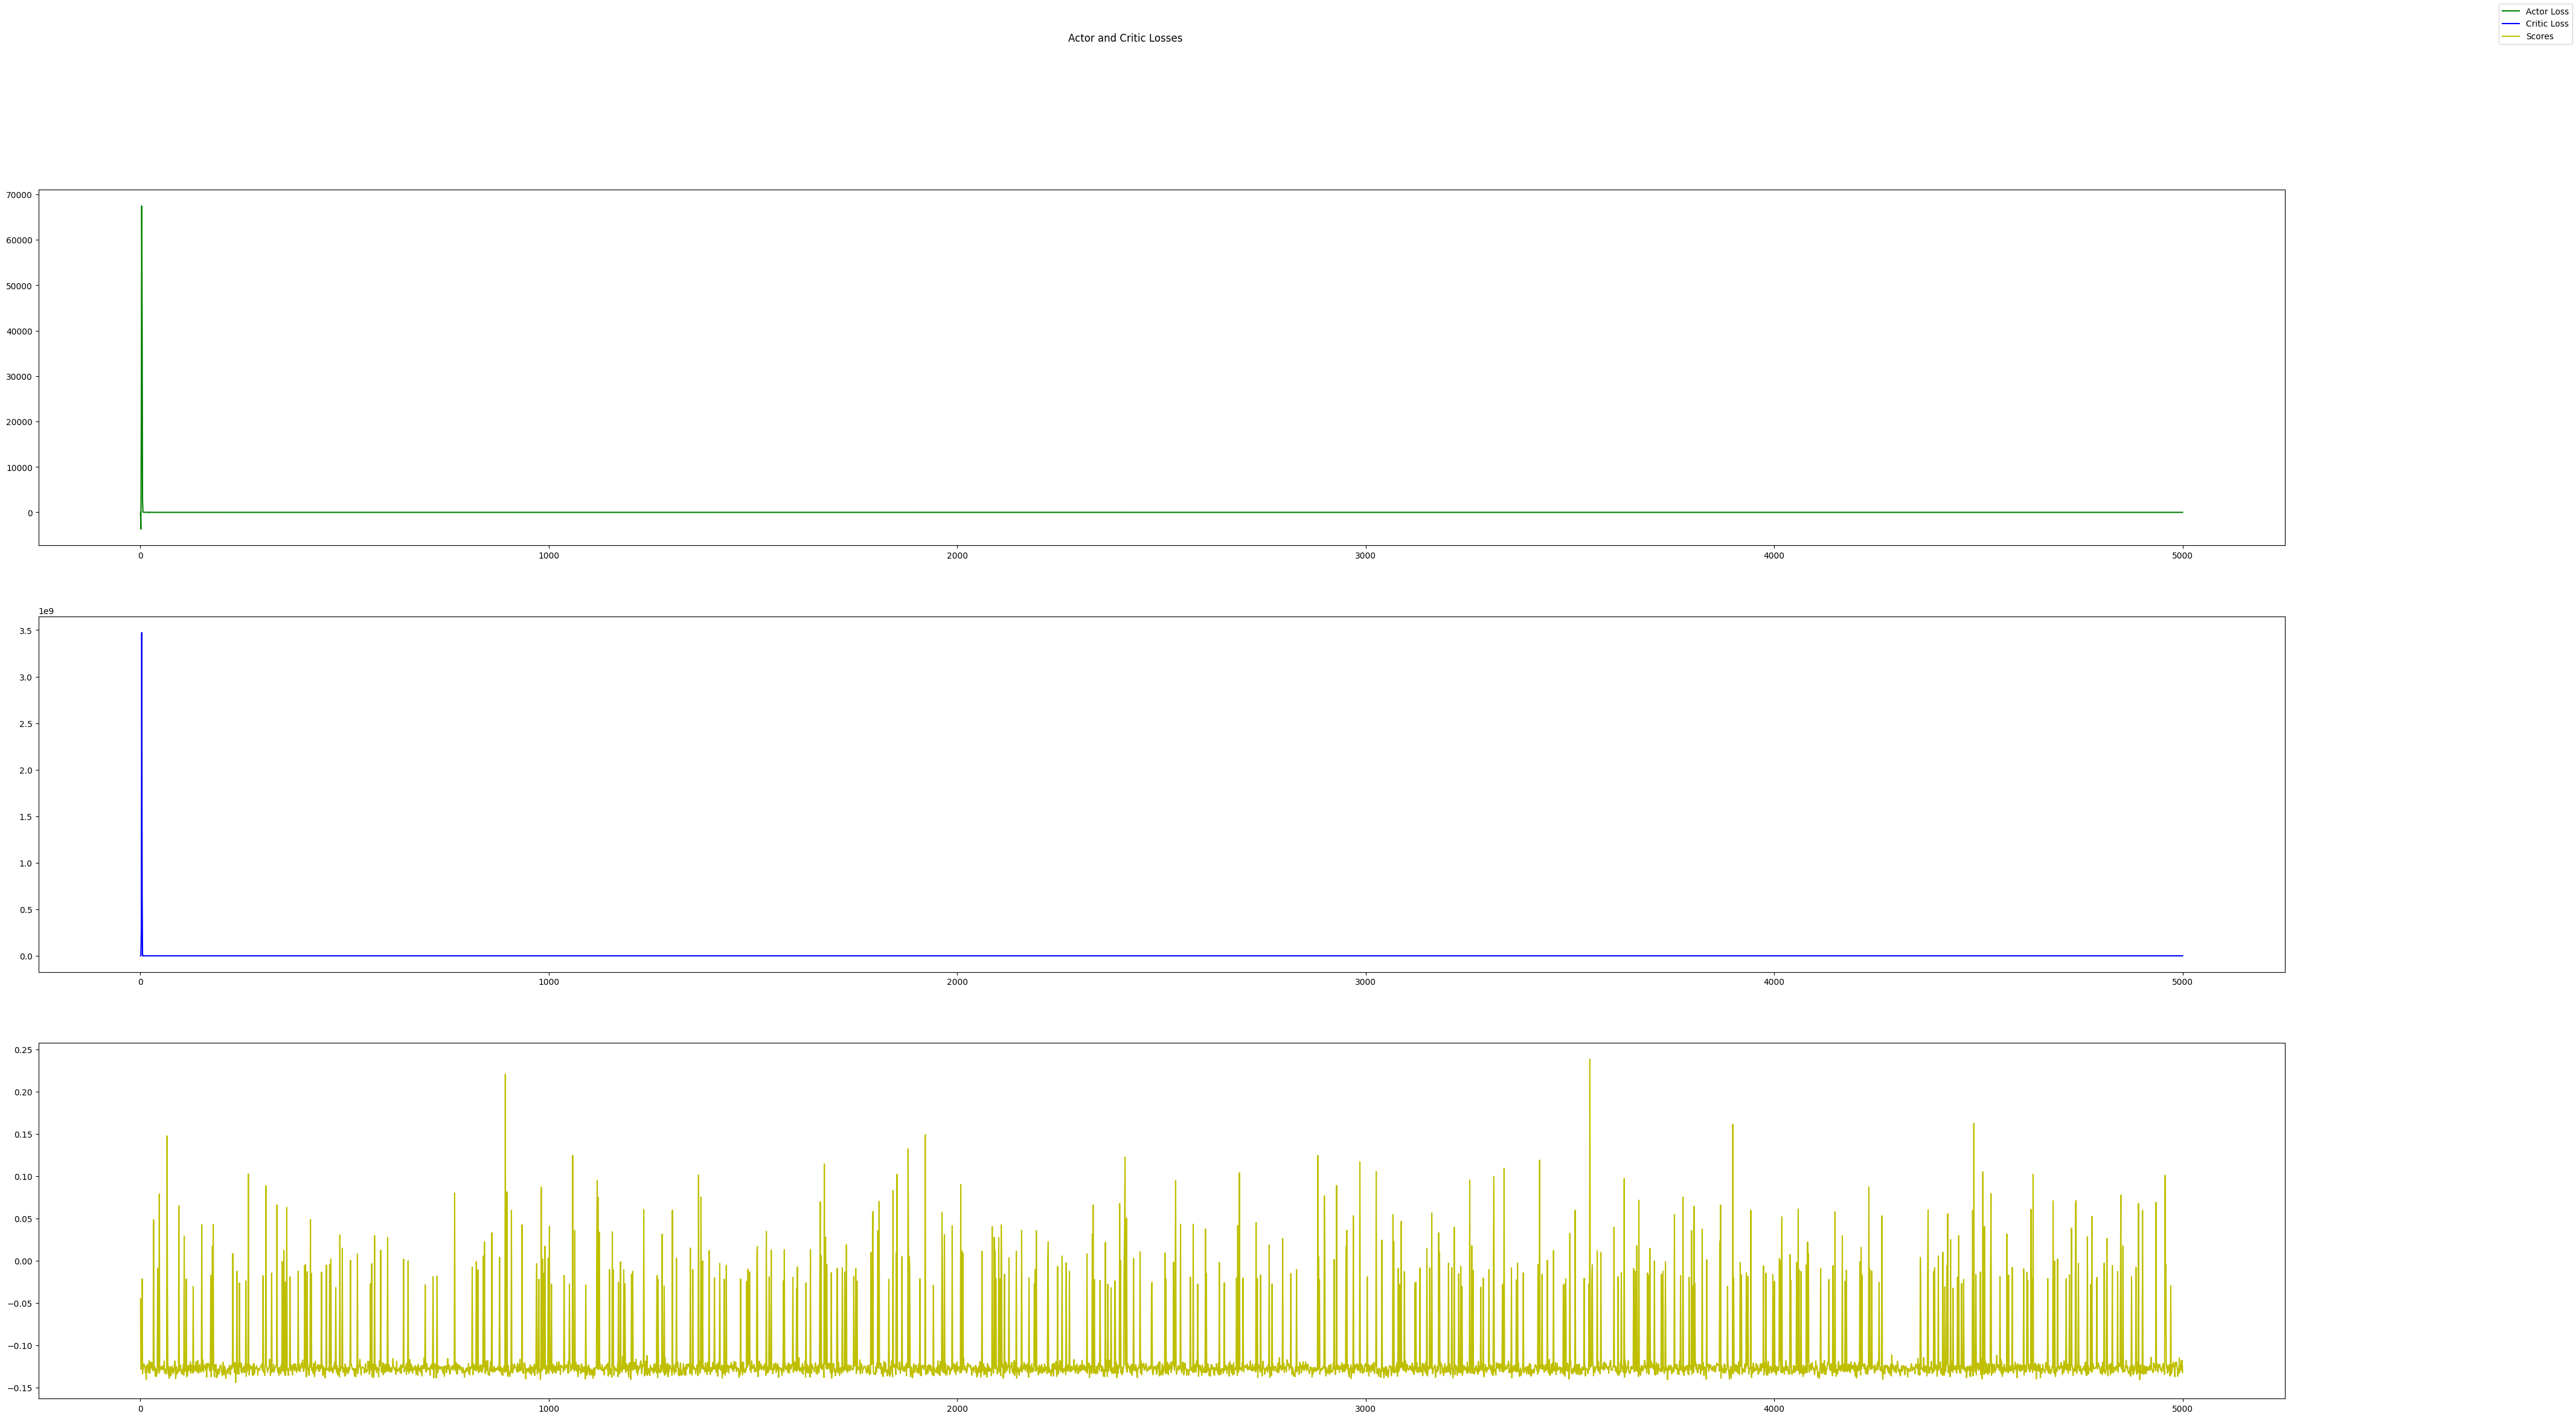

In [6]:
a2c = ActorCritic(actor, critic)

a2c.train()

a2c.save('final_mountain')

In [5]:
from gym.wrappers import RecordVideo

In [10]:
def Evaluate(agent, n_eval_episodes):
    rewards = []

    agent.load('final_mountain')

    val_env = gym.make(
            id='MountainCarContinuous-v0',
            render_mode='rgb_array',          
        )
    val_env = RecordVideo(val_env, 'videomcar', episode_trigger=lambda x: x==2, video_length=0)
    for n_episode in range(n_eval_episodes):
        episode_rewards = 0
        obs = val_env.reset()[0]
        val_env.start_video_recorder()
        done = False

        while not done:
            
            action, _ = agent.actor.act(torch.from_numpy(obs))
            obs_next, rew, terminated, truncated, _ = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            #val_env.render()
            episode_rewards += rew
            obs = obs_next
            if done:
                val_env.close_video_recorder()

        print('Reward episode %d: %d' %(n_episode, episode_rewards))

        rewards.append(episode_rewards)

    print('Mean Reward: ', np.mean(rewards))
    val_env.close()

actor = Actor(2,64,1, 1e-2)
critic = Critic(2,48,1, 1e-2)
ac = ActorCritic(actor, critic)
Evaluate(ac, 3)

/home/brock/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-0.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-0.mp4
Reward episode 0: -89
Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-1.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-1.mp4
Reward episode 1: 14
Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-2.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-2.mp4
Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-2.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/videomcar/rl-video-episode-2.mp4
Reward episode 2: 20
Mean Reward:  -18.251285657412954
